# Replicate GluNet on OhioT1DM

GluNet was mainly reported as a personalized model

In [1]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Functions

## 1. Load in the Glucose, Meal, and Insulin data

For cgm data, do general seperation based on time interval = 1hour:

smaller than 1 hour, do spline interpolation (later)

larger than 1 hour, seperate it as another dataset for training

In [2]:
# filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/559-ws-training.xml"
# tree = ET.parse(filepath)
# root = tree.getroot()

# for child in root:
#     print(child.tag)

In [3]:
def round_up_to_nearest_five_minutes(ts):
    # Parse the timestamp
    dt = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
    
    # Calculate minutes to add to round up to the nearest 5 minutes
    minutes_to_add = (5 - dt.minute % 5) % 5
    if minutes_to_add == 0 and dt.second == 0:
        # If exactly on a 5 minute mark and second is 0, no need to add time
        minutes_to_add = 5
    
    # Add the necessary minutes
    new_dt = dt + timedelta(minutes=minutes_to_add)
    
    # Return the new timestamp in the same format
    return new_dt.strftime( "%d-%m-%Y %H:%M:%S")

In [4]:
# Need to set the 
def read_ohio(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts'])
            entry0['ts'] = adjusted_ts
        ts = entry0['ts']
        entry0['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            # t1 = datetime.datetime.strptime(entry["ts"], "%d-%m-%Y %H:%M:%S")
            # t0 = datetime.datetime.strptime(last_entry["ts"], "%d-%m-%Y %H:%M:%S")
            # delt = t1 - t0
            # if category == "glucose_level":
            #     if delt <= interval_timedelta:
            #         res[-1].append([entry])
            #     else:
            #         res.append([entry])
            # else:
            ts = entry['ts']
            if round == True:
                adjusted_ts = round_up_to_nearest_five_minutes(ts)
                entry['ts'] = adjusted_ts
            entry['ts'] = datetime.strptime(ts, "%d-%m-%Y %H:%M:%S")
            res.append([entry])
    return res


In [5]:
filepath = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/train/570-ws-training.xml"
glucose = read_ohio(filepath, "glucose_level", False)

In [6]:
glucose[:5]

[[{'ts': datetime.datetime(2021, 12, 7, 16, 29), 'value': '101'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 34), 'value': '100'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 39), 'value': '100'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 44), 'value': '99'}],
 [{'ts': datetime.datetime(2021, 12, 7, 16, 49), 'value': '98'}]]

# Threshold filter

The paper didn't report how did they do the threshold filtering, and didn't provide the filter value. So in this case, to avoid bias, we should? not conduct any threshold filtering

In [7]:
glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

# Create the multi-channel database
g_data = []
for timestamp in glucose_dict:
    record = {
        'timestamp': timestamp,
        'glucose_value': glucose_dict[timestamp],
        # 'meal_type': None,
        # 'meal_carbs': 0
    }
    
    g_data.append(record)

In [8]:
# Create DataFrame
glucose_df = pd.DataFrame(g_data)

# Convert glucose values to numeric type for analysis
glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])
glucose_df['glucose_value'] = glucose_df['glucose_value'] / 100

# Calculate percentiles
lower_percentile = np.percentile(glucose_df['glucose_value'], 2)
upper_percentile = np.percentile(glucose_df['glucose_value'], 98)

# Print thresholds
print(f"2% lower threshold: {lower_percentile}")
print(f"98% upper threshold: {upper_percentile}")

2% lower threshold: 0.71
98% upper threshold: 3.08


In [9]:
glucose_df

,timestamp,glucose_value
0,2021-12-07 16:29:00,1.01
1,2021-12-07 16:34:00,1.00
2,2021-12-07 16:39:00,1.00
3,2021-12-07 16:44:00,0.99
4,2021-12-07 16:49:00,0.98
...,...,...
10977,2022-01-16 23:39:00,1.13
10978,2022-01-16 23:44:00,1.18
10979,2022-01-16 23:49:00,1.20
10980,2022-01-16 23:54:00,1.23


# Spline interpolation and extrapolation
: Spline interpolation or extrapolation technique are used when the missing CGM data are less than one
hour (12 samples). Spline interpolation is implemented because
it is more accurate, and simpler than some other methods [24].
If the missing CMG data are longer than 1 hour, we consider it
as a separate dataset in training. In the inference, extrapolation
is adopted because future samples cannot be used in forecasting.

In [10]:
# Example DataFrame setup
# data = {
#     'timestamp': pd.to_datetime([
#         '2021-12-07 01:17:00', '2021-12-07 01:22:00', '2021-12-07 01:27:00', '2021-12-07 01:32:00', '2021-12-07 01:37:00',
#         '2021-12-07 04:00:00',  # Large gap example
#         '2021-12-07 06:00:00',  # Another large gap example
#         '2022-01-17 23:36:00', '2022-01-17 23:41:00', '2022-01-17 23:46:00', '2022-01-17 23:51:00', '2022-01-17 23:56:00'
#     ]),
#     'glucose_value': [101, 98, 104, 112, 120, 130, 135, 161, 164, 168, 172, 176]
# }
# glucose_df

def segement_data_as_1hour(data):
    df = pd.DataFrame(data)

    # Calculate time differences
    df['time_diff'] = df['timestamp'].diff()

    # Identify large gaps
    df['new_segment'] = df['time_diff'] > pd.Timedelta(hours=1)

    # Find indices where new segments start
    segment_starts = df[df['new_segment']].index

    # Initialize an empty dictionary to store segments
    segments = {}
    prev_index = 0

    # Loop through each segment start and slice the DataFrame accordingly
    for i, start in enumerate(segment_starts, 1):
        segments[f'segment_{i}'] = df.iloc[prev_index:start].reset_index(drop=True)
        prev_index = start

    # Add the last segment from the last gap to the end of the DataFrame
    segments[f'segment_{len(segment_starts) + 1}'] = df.iloc[prev_index:].reset_index(drop=True)

    # Optionally remove helper columns from each segment
    for segment in segments.values():
        segment.drop(columns=['time_diff', 'new_segment'], inplace=True)
    
    return segments

# Example: print each segment
segments = segement_data_as_1hour(glucose_df)




In [11]:
def detect_missing_and_spline_interpolate(segments):
    for sequence in segments:
        # sequence = "segment_3"
        detected_missing = 0
        for ts in range(len( segments[sequence]['timestamp'])-1):
            if segments[sequence]['timestamp'][ts+1] - segments[sequence]['timestamp'][ts] > timedelta(minutes = 6):
                print(sequence)
                print("before: ", segments[sequence]['timestamp'][ts])
                print("after: ", segments[sequence]['timestamp'][ts+1])
                detected_missing = 1
            
        if detected_missing == 1:
            datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
            reference_time = min(segments[sequence]['timestamp'])

            # Convert datetime objects to the number of seconds since the reference time
            datetime_seconds_since_start = [((dt - reference_time).total_seconds())/60 for dt in datetime_list] # Make it into minute
            original_timestamp_in_segement = [((dt - reference_time).total_seconds())/60 for dt in segments[sequence]['timestamp']]

            x = original_timestamp_in_segement
            y = np.array(segments[sequence]['glucose_value'])
            cs = CubicSpline(x, y)
            xs = datetime_seconds_since_start

            interpolated_xs = cs(xs)
            time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')

            # Create DataFrame from the time index and glucose values
            df_interpolated = pd.DataFrame({'timestamp': time_index_interpolated, 'glucose_value': interpolated_xs})
            segments[sequence] = df_interpolated

    return segments

                

In [12]:
interpolated_segements = detect_missing_and_spline_interpolate(segments)

segment_1
before:  2021-12-07 22:14:00
after:  2021-12-07 22:34:00
segment_6
before:  2021-12-22 17:03:00
after:  2021-12-22 18:03:00
segment_6
before:  2021-12-22 20:18:00
after:  2021-12-22 20:28:00
segment_8
before:  2021-12-27 07:53:00
after:  2021-12-27 08:28:00
segment_9
before:  2022-01-02 07:32:00
after:  2022-01-02 08:27:00


C:\Users\username\AppData\Local\Temp\ipykernel_19484\2206620972.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
C:\Users\username\AppData\Local\Temp\ipykernel_19484\2206620972.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


# Align other factors with the glucose information

## Include meal info

In [13]:
meal = read_ohio(filepath, "meal", False)

flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)

meal_df['assigned'] = False


In [14]:
# Function to align and update segments with meal data
def find_closest_glucose_index(glucose_df, meal_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - meal_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_meals(segments, meal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['carbs'] = 0

        for index, meal_row in meal_df.iterrows():
            meal_time = meal_row['ts']
            closest_glucose_idx = find_closest_glucose_index(segment_df, meal_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'carbs'] = int(meal_row['carbs'])/100
                meal_df.loc[index, 'assigned'] = True


    return segments

# Update the segments with meal data
meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)


C:\Users\username\AppData\Local\Temp\ipykernel_19484\2092148408.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.65' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'carbs'] = int(meal_row['carbs'])/100
C:\Users\username\AppData\Local\Temp\ipykernel_19484\2092148408.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'carbs'] = int(meal_row['carbs'])/100
C:\Users\username\AppData\Local\Temp\ipykernel_19484\2092148408.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.85' has dtype incompatible with int64, please explicitly cas

## Include the basal information

In [15]:
basal = read_ohio(filepath, "basal", False)

flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
basal_df = pd.DataFrame(flattened_basal_data)

basal_df['assigned'] = False
basal_df['end_ts'] = basal_df['ts'].shift(-1)
basal_df[:10]

,ts,value,assigned,end_ts
0,2021-12-07 00:00:00,0.93,False,2021-12-07 04:00:00
1,2021-12-07 04:00:00,1.1,False,2021-12-07 05:00:00
2,2021-12-07 05:00:00,1.25,False,2021-12-07 07:00:00
3,2021-12-07 07:00:00,1.3,False,2021-12-07 11:00:00
4,2021-12-07 11:00:00,0.7,False,2021-12-07 17:00:00
5,2021-12-07 17:00:00,0.9,False,2021-12-08 00:00:00
6,2021-12-08 00:00:00,0.93,False,2021-12-08 04:00:00
7,2021-12-08 04:00:00,1.1,False,2021-12-08 05:00:00
8,2021-12-08 05:00:00,1.25,False,2021-12-08 07:00:00
9,2021-12-08 07:00:00,1.3,False,2021-12-08 11:00:00


In [16]:
basal_df[:30]

,ts,value,assigned,end_ts
0,2021-12-07 00:00:00,0.93,False,2021-12-07 04:00:00
1,2021-12-07 04:00:00,1.1,False,2021-12-07 05:00:00
2,2021-12-07 05:00:00,1.25,False,2021-12-07 07:00:00
3,2021-12-07 07:00:00,1.3,False,2021-12-07 11:00:00
4,2021-12-07 11:00:00,0.7,False,2021-12-07 17:00:00
5,2021-12-07 17:00:00,0.9,False,2021-12-08 00:00:00
6,2021-12-08 00:00:00,0.93,False,2021-12-08 04:00:00
7,2021-12-08 04:00:00,1.1,False,2021-12-08 05:00:00
8,2021-12-08 05:00:00,1.25,False,2021-12-08 07:00:00
9,2021-12-08 07:00:00,1.3,False,2021-12-08 11:00:00


In [17]:
# Function to align and update segments with meal data
def update_segments_with_basal(segments, basal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['basal_rate'] = None

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            for _, basal_row in basal_df.iterrows():
                if basal_row['ts'] <= row['timestamp'] < (basal_row['end_ts'] if pd.notna(basal_row['end_ts']) else pd.Timestamp('2099-12-31')):
                    segment_df.at[i, 'basal_rate'] = basal_row['value']
                    break

    return segments

# Update the segments with meal data
basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)


## Include bolus

In [58]:
# Read in bolus and temp basal information
# Need to set the 
def read_ohio_bolus_tempbasal(filepath, category, round):
    tree = ET.parse(filepath)
    root = tree.getroot()
    # interval_timedelta = datetime.timedelta(minutes=interval_timedelta)

    res = []
    for item in root.findall(category):
        if len(item) == 0:
            continue  # Skip if the item has no children
            
        entry0 = item[0].attrib
        if round == True:
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_begin'])
            entry0['ts_begin'] = adjusted_ts
            adjusted_ts = round_up_to_nearest_five_minutes(entry0['ts_end'])
            entry0['ts_end'] = adjusted_ts
        
        entry0['ts_begin'] = datetime.strptime(entry0['ts_begin'], "%d-%m-%Y %H:%M:%S")
        entry0['ts_end'] = datetime.strptime(entry0['ts_end'], "%d-%m-%Y %H:%M:%S")

        res.append([entry0])
        for i in range(1, len(item)):
            # last_entry = item[i - 1].attrib
            entry = item[i].attrib
            ts_begin = entry['ts_begin']
            ts_end = entry['ts_end']
            if round == True:
                adjusted_ts_begin = round_up_to_nearest_five_minutes(ts_begin)
                entry['ts_end'] = adjusted_ts_begin
                adjusted_ts_end = round_up_to_nearest_five_minutes(ts_end)
                entry['ts_end'] = adjusted_ts_end
            entry['ts_begin'] = datetime.strptime(entry['ts_begin'], "%d-%m-%Y %H:%M:%S")
            entry['ts_end'] = datetime.strptime(entry['ts_end'], "%d-%m-%Y %H:%M:%S")
            if category == "bolus":
                if entry['ts_begin'] != entry['ts_end']:
                    print("Unequal: begin: " + str(entry['ts_begin']) + "end: " + str(entry['ts_end']))
            res.append([entry])
    return res

In [19]:
# Merge Bolus into the dataframe
bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)


Unequal: begin: 2021-12-07 07:41:58end: 2021-12-07 08:11:58
Unequal: begin: 2021-12-07 18:34:32end: 2021-12-07 19:04:32
Unequal: begin: 2021-12-08 06:18:52end: 2021-12-08 06:48:52
Unequal: begin: 2021-12-08 12:09:16end: 2021-12-08 12:39:16
Unequal: begin: 2021-12-08 16:50:52end: 2021-12-08 17:20:52
Unequal: begin: 2021-12-08 19:26:31end: 2021-12-08 19:56:31
Unequal: begin: 2021-12-08 21:36:59end: 2021-12-08 22:06:59
Unequal: begin: 2021-12-09 06:29:18end: 2021-12-09 06:59:18
Unequal: begin: 2021-12-09 12:04:48end: 2021-12-09 12:34:48
Unequal: begin: 2021-12-09 19:42:56end: 2021-12-09 20:12:56
Unequal: begin: 2021-12-10 06:11:17end: 2021-12-10 06:41:17
Unequal: begin: 2021-12-10 13:31:26end: 2021-12-10 14:01:26
Unequal: begin: 2021-12-10 19:59:05end: 2021-12-10 20:29:05
Unequal: begin: 2021-12-11 09:26:02end: 2021-12-11 09:56:02
Unequal: begin: 2021-12-11 16:57:23end: 2021-12-11 17:27:23
Unequal: begin: 2021-12-11 20:20:42end: 2021-12-11 20:50:42
Unequal: begin: 2021-12-12 10:07:10end: 

In [20]:
flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist

# Convert to DataFrame
bolus_df = pd.DataFrame(flattened_bolus_data)

bolus_df['assigned'] = False
bolus_df[:10]

,ts_begin,ts_end,type,dose,bwz_carb_input,assigned
0,2021-12-07 07:36:54,2021-12-07 07:36:54,normal dual,8.0,102,False
1,2021-12-07 07:41:58,2021-12-07 08:11:58,square dual,6.4,0,False
2,2021-12-07 18:31:52,2021-12-07 18:31:52,normal dual,4.0,65,False
3,2021-12-07 18:34:32,2021-12-07 19:04:32,square dual,4.1,0,False
4,2021-12-07 22:19:46,2021-12-07 22:19:46,normal,0.7,0,False
5,2021-12-08 06:14:22,2021-12-08 06:14:22,normal dual,6.7,97,False
6,2021-12-08 06:18:52,2021-12-08 06:48:52,square dual,6.1,0,False
7,2021-12-08 12:04:11,2021-12-08 12:04:11,normal dual,9.6,120,False
8,2021-12-08 12:09:16,2021-12-08 12:39:16,square dual,7.5,0,False
9,2021-12-08 15:46:52,2021-12-08 15:46:52,normal,2.9,0,False


In [21]:
# Function to align and update segments with meal data
def find_closest_glucose_index(glucose_df, bolus_time, threshold_seconds=300):
    time_diffs = (glucose_df['timestamp'] - bolus_time).abs()
    within_threshold = time_diffs < pd.Timedelta(seconds=threshold_seconds)
    if within_threshold.any():
        closest_index = time_diffs[within_threshold].idxmin()
        return closest_index
    return None

def update_segments_with_bolus(segments, bolus_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        segment_df['bolus_dose'] = 0

        for index, bolus_row in bolus_df.iterrows():
            bolus_time = bolus_row['ts_begin']
            closest_glucose_idx = find_closest_glucose_index(segment_df, bolus_time)
            
            if closest_glucose_idx is not None:
                segment_df.loc[closest_glucose_idx, 'bolus_dose'] = float(bolus_row['dose']) /10
                bolus_df.loc[index, 'assigned'] = True


    return segments

In [22]:
bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)

C:\Users\username\AppData\Local\Temp\ipykernel_19484\4050523474.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'bolus_dose'] = float(bolus_row['dose']) /10
C:\Users\username\AppData\Local\Temp\ipykernel_19484\4050523474.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.62' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.loc[closest_glucose_idx, 'bolus_dose'] = float(bolus_row['dose']) /10
C:\Users\username\AppData\Local\Temp\ipykernel_19484\4050523474.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5900000000000001' has dtype incompatible with i

## Include temp_basal

In [23]:
tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)

In [24]:
flattened_tempbasal_data = [item[0] for item in tempbasal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
tempbasal_df = pd.DataFrame(flattened_tempbasal_data)

tempbasal_df['assigned'] = False
tempbasal_df[:10]

,ts_begin,ts_end,value,assigned
0,2021-12-25 23:25:00,2021-12-26 01:25:00,0.0,False
1,2021-12-28 00:00:01,2021-12-28 01:33:11,0.0,False
2,2021-12-31 00:32:21,2021-12-31 02:32:00,0.0,False


In [25]:
# Function to align and update segments with meal data
def update_segments_with_tempbasal(segments, tempbasal_df):
    for segment_name, segment_df in segments.items():
        # Initialize the 'carbs' column to zeros
        # segment_df['basal_rate'] = None

        # Iterate through each timestamp in the segment
        for i, row in segment_df.iterrows():
            # Find the closest meal timestamp and its carb information
            for _, tempbasal_row in tempbasal_df.iterrows():
                if tempbasal_row['ts_begin'] <= row['timestamp'] < tempbasal_row['ts_end']:
                    segment_df.at[i, 'basal_rate'] = tempbasal_row['value']
                    break

    return segments

# Update the segments with meal data
final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)

In [26]:
final_updated_segments["segment_1"][:30]

,timestamp,glucose_value,carbs,basal_rate,bolus_dose
0,2021-12-07 16:29:00,1.01,0.00,0.7,0.00
1,2021-12-07 16:34:00,1.00,0.00,0.7,0.00
2,2021-12-07 16:39:00,1.00,0.00,0.7,0.00
3,2021-12-07 16:44:00,0.99,0.00,0.7,0.00
4,2021-12-07 16:49:00,0.98,0.00,0.7,0.00
5,2021-12-07 16:54:00,0.98,0.00,0.7,0.00
6,2021-12-07 16:59:00,0.95,0.00,0.7,0.00
7,2021-12-07 17:04:00,0.94,0.00,0.9,0.00
8,2021-12-07 17:09:00,0.92,0.00,0.9,0.00
9,2021-12-07 17:14:00,0.90,0.00,0.9,0.00


# Construct X and y, training and test

In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [28]:
def label_delta_transform(labels_list):
    # label_lower_percentile = -12.75
    # label_upper_percentile = 12.85
    label_lower_percentile = np.percentile(labels_list, 1)
    label_upper_percentile = np.percentile(labels_list, 99)
    # label_lower_percentile = min(labels_list)
    # label_upper_percentile = max(labels_list)
    print("The label_lower_percentile is ", label_lower_percentile)
    print("The label_upper_percentile is ", label_upper_percentile)
    transformed_labels = []
    for label in labels_list:
        if label <= label_lower_percentile:
            transformed_labels.append(0)
        elif label_lower_percentile < label < label_upper_percentile:
            trans_label = round((255/(label_upper_percentile - label_lower_percentile))*(label + abs(label_lower_percentile)))
            transformed_labels.append(trans_label)
        elif label >= label_upper_percentile:
            transformed_labels.append(255)
    return transformed_labels

In [29]:
def prepare_dataset(segments):
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
        segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
        segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        max_index = len(segment_df) - 22  # Subtracting 22 because we need to predict index + 21 and need index + 15 to exist
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index + 1):
            # Extracting features from index i to i+15
            features = segment_df.loc[i:i+15, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values#.flatten()
            # Extracting label for index i+21
            # Do the label transform
            label = segment_df.loc[i+21, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+21, 'glucose_value'])
            features_list.append(features)
            labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    print("len of labels_list " + str(len(labels_list)))
    new_labels_list = label_delta_transform(labels_list)    
    print("after label transform. the len of label list "+str(len(new_labels_list)))    
    return features_list, labels_list, new_labels_list, raw_glu_list
    
    # # Convert lists to PyTorch tensors
    # features_tensor = torch.tensor(features_list, dtype=torch.float32)
    # labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D
    
    # return TensorDataset(features_tensor, labels_tensor)

In [48]:
features_list, labels_list, new_labels_list, raw_glu_list = prepare_dataset(final_updated_segments)

len of features_list 10677
len of labels_list 10677
The label_lower_percentile is  -0.5599999999999998
The label_upper_percentile is  0.59
after label transform. the len of label list 10677


In [49]:
features_list

[array([[1.01, 0.  , 0.7 , 0.  ],
        [1.  , 0.  , 0.7 , 0.  ],
        [1.  , 0.  , 0.7 , 0.  ],
        [0.99, 0.  , 0.7 , 0.  ],
        [0.98, 0.  , 0.7 , 0.  ],
        [0.98, 0.  , 0.7 , 0.  ],
        [0.95, 0.  , 0.7 , 0.  ],
        [0.94, 0.  , 0.9 , 0.  ],
        [0.92, 0.  , 0.9 , 0.  ],
        [0.9 , 0.  , 0.9 , 0.  ],
        [0.87, 0.  , 0.9 , 0.  ],
        [0.86, 0.  , 0.9 , 0.  ],
        [0.85, 0.  , 0.9 , 0.  ],
        [0.85, 0.  , 0.9 , 0.  ],
        [0.86, 0.  , 0.9 , 0.  ],
        [0.85, 0.  , 0.9 , 0.  ]]),
 array([[1.  , 0.  , 0.7 , 0.  ],
        [1.  , 0.  , 0.7 , 0.  ],
        [0.99, 0.  , 0.7 , 0.  ],
        [0.98, 0.  , 0.7 , 0.  ],
        [0.98, 0.  , 0.7 , 0.  ],
        [0.95, 0.  , 0.7 , 0.  ],
        [0.94, 0.  , 0.9 , 0.  ],
        [0.92, 0.  , 0.9 , 0.  ],
        [0.9 , 0.  , 0.9 , 0.  ],
        [0.87, 0.  , 0.9 , 0.  ],
        [0.86, 0.  , 0.9 , 0.  ],
        [0.85, 0.  , 0.9 , 0.  ],
        [0.85, 0.  , 0.9 , 0.  ],
        [0.8

In [90]:
min(new_labels_list)

0

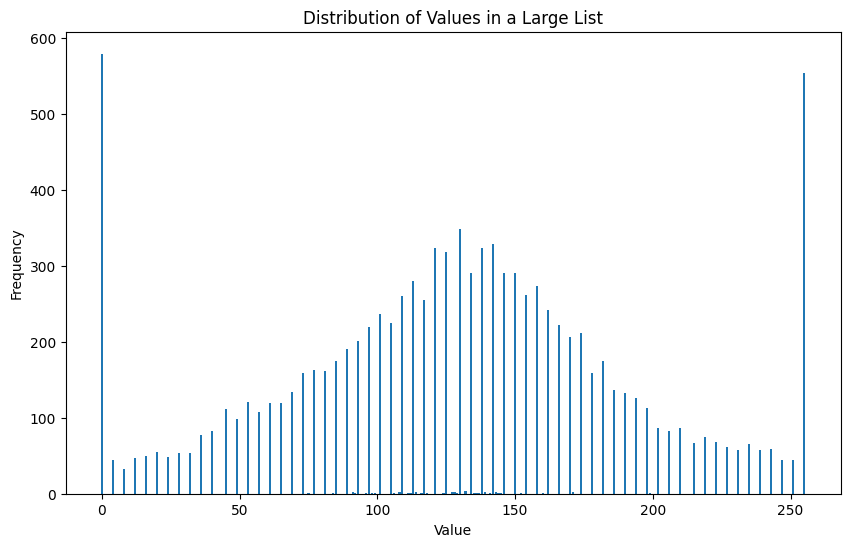

In [91]:
# Counting the frequency of each value
from collections import Counter
value_counts = Counter(new_labels_list)

# Extracting the values and their corresponding counts
values = list(value_counts.keys())
frequencies = list(value_counts.values())

# Plotting the distribution in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(values, frequencies)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values in a Large List')
plt.show()

In [92]:
values.sort()
values

[0,
 4,
 8,
 12,
 16,
 20,
 24,
 28,
 32,
 36,
 40,
 45,
 49,
 53,
 57,
 61,
 65,
 69,
 73,
 75,
 77,
 81,
 84,
 85,
 89,
 91,
 92,
 93,
 96,
 97,
 98,
 99,
 101,
 105,
 106,
 108,
 109,
 111,
 112,
 113,
 114,
 116,
 117,
 118,
 121,
 124,
 125,
 127,
 128,
 129,
 130,
 132,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 150,
 152,
 154,
 158,
 160,
 162,
 166,
 170,
 171,
 174,
 178,
 182,
 186,
 190,
 194,
 198,
 199,
 202,
 206,
 210,
 215,
 219,
 223,
 227,
 231,
 235,
 239,
 243,
 247,
 251,
 255]

From the paper, they use -12.7 and 12.8 as the range to assign 1 to 256 to each label. I'm curious is the range fixed or can be adjusted based on the actual range of delta_G.

To avoid obscure issue when recover the label, we use 10 and 90 percentile as the range instead of -12.7 and 12.8.


In [93]:
import torch
import torch.utils.data

class PreparedDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.target_length = len(labels)

    def __getitem__(self, idx):
        # Retrieve the feature and label for the given index
        feature = self.features[idx]
        label = self.labels[idx]

        # Convert feature to a PyTorch tensor and reshape it to (4, 16)
        feature_tensor = torch.tensor(feature, dtype=torch.float32).T#.view(4, 16)
        
        # Convert label to a PyTorch tensor
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return feature_tensor, label_tensor

    def __len__(self):
        return len(self.features)


data = PreparedDataset(features_list, new_labels_list)
print('The dataset has ' + str(len(data)) + ' items')
print('Shape of data[0][0]:', data[0][0].shape)
print('Value of data[0][1]:', data[0][1])

The dataset has 10677 items
Shape of data[0][0]: torch.Size([4, 16])
Value of data[0][1]: tensor(162)


In [77]:
data[0][0]

tensor([[1.0100, 1.0000, 1.0000, 0.9900, 0.9800, 0.9800, 0.9500, 0.9400, 0.9200,
         0.9000, 0.8700, 0.8600, 0.8500, 0.8500, 0.8600, 0.8500],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

# Build the dilate CNN

Using code from Github:

## Pytorch

Still in old pytorch version

In [47]:
# # Convert lists to PyTorch tensors
# features_tensor = torch.tensor(features_list, dtype=torch.float32)
# labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D

# feature_label_tensor = TensorDataset(features_tensor, labels_tensor)


# train_loader = DataLoader(feature_label_tensor, batch_size=32, shuffle=True)

# # Example of using DataLoader in a training loop
# for features, labels in train_loader:
#     print("Features batch shape:", features.shape)
#     print("Label batch shape:", labels.shape)
#     # Example: print(features, labels)
#     break

In [48]:
import torch
from wavenet_model import *
from audio_data import WavenetDataset
from wavenet_training import *

from model_logging import *

In [58]:
# initialize cuda option
dtype = torch.FloatTensor # data type
ltype = torch.LongTensor # label type

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use gpu')
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

use gpu


In [106]:
dtype = torch.FloatTensor

# Initialize the model
model = WaveNetModel(layers=4,
                     blocks=1,
                     dilation_channels=64,
                     residual_channels=64,
                     skip_channels=256,
                     end_channels=256, 
                     in_channels=4,  # Number of input features
                     classes=256,    # Define the number of output classes
                     output_length=1,
                     dtype=dtype, 
                     bias=True)

print('model: ', model)
print('receptive field: ', model.receptive_field)
print('parameter count: ', model.parameter_count())

model:  WaveNetModel(
  (filter_convs): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  )
  (gate_convs): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(2,), stride=(1,))
  )
  (residual_convs): ModuleList(
    (0-3): 4 x Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  )
  (skip_convs): ModuleList(
    (0-3): 4 x Conv1d(64, 256, kernel_size=(1,), stride=(1,))
  )
  (start_conv): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
  (end_conv_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
  (end_conv_2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
)
receptive field:  16
parameter count:  281152


In [107]:
# data = WavenetDataset(dataset_file='train_samples/bach_chaconne/dataset.npz',
#                       item_length=model.receptive_field + model.output_length - 1,
#                       target_length=model.output_length,
#                       file_location='train_samples/bach_chaconne',
#                       test_stride=500)
# print('the dataset has ' + str(len(data)) + ' items')

In [108]:
# for i in range(5):
#     x, target = data[i]
#     print(f"Sample {i} - x: {x.shape}, target: {target}")

In [109]:
dataloader = torch.utils.data.DataLoader(data,
                                        batch_size=32,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=False)

In [110]:
# for batch_idx, (x, target) in enumerate(dataloader):
#     print(f"Batch {batch_idx} - x: {x.shape}, target: {target.shape}")
#     if batch_idx >= 5:  # Only print the first 5 batches
#         break

In [111]:
trainer = WavenetTrainer(model=model,
                         dataset=data,
                         lr=0.001)

print('start training...')
trained_model = trainer.train(batch_size=32,
              epochs=5, 
              dataloader = dataloader)

start training...
Epoch 0 start
Epoch: 0 [0/10677 (0%)]	Loss: 5.549896
Epoch: 0 [320/10677 (3%)]	Loss: 5.252642
Epoch: 0 [640/10677 (6%)]	Loss: 4.069805
Epoch: 0 [960/10677 (9%)]	Loss: 4.175902
Epoch: 0 [1280/10677 (12%)]	Loss: 3.912432
loss at step 50: 7.092169222831726
Epoch: 0 [1600/10677 (15%)]	Loss: 4.153615
Epoch: 0 [1920/10677 (18%)]	Loss: 4.633851
Epoch: 0 [2240/10677 (21%)]	Loss: 4.167787
Epoch: 0 [2560/10677 (24%)]	Loss: 4.164449
Epoch: 0 [2880/10677 (27%)]	Loss: 4.047335
loss at step 100: 4.063403654098511
Epoch: 0 [3200/10677 (30%)]	Loss: 3.767573
Epoch: 0 [3520/10677 (33%)]	Loss: 4.294414
Epoch: 0 [3840/10677 (36%)]	Loss: 3.777779
Epoch: 0 [4160/10677 (39%)]	Loss: 3.709383
Epoch: 0 [4480/10677 (42%)]	Loss: 3.817970
loss at step 150: 3.950238356590271
Epoch: 0 [4800/10677 (45%)]	Loss: 3.744524
Epoch: 0 [5120/10677 (48%)]	Loss: 4.172096
Epoch: 0 [5440/10677 (51%)]	Loss: 3.884676
Epoch: 0 [5760/10677 (54%)]	Loss: 4.108523
Epoch: 0 [6080/10677 (57%)]	Loss: 3.983379
loss at ste

In [112]:
import torch
from torch.autograd import Variable

def test_single_batch(model, dataloader):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Fetch a single batch of data
    for x, target in dataloader:
        # Assuming no need for Variable anymore
        x = x  # if using an old version of PyTorch, wrap with Variable(x)
        target = target  # if using an old version of PyTorch, wrap with Variable(target)

        # Forward pass to get output/logits
        output = model(x)

        # Apply softmax to convert logits to probabilities
        probabilities = torch.softmax(output, dim=1)

        # Get predicted classes
        _, predicted_classes = torch.max(probabilities, dim=1)

        # Print outputs
        print("Output logits:", output)
        print("Probabilities:", probabilities)
        print("Predicted classes:", predicted_classes)
        print("Target labels:", target)

        # Only process one batch
        break
    return predicted_classes, probabilities

# Assuming `model` is your trained model and `dataloader` is setup correctly
prediction_class, probabilities = test_single_batch(trained_model, dataloader)

Output logits: tensor([[-0.0305, -6.9209, -7.1128,  ..., -6.9136, -7.0887,  1.3473],
        [-0.0302, -6.9243, -7.1165,  ..., -6.9171, -7.0922,  1.3477],
        [-0.0368, -6.9312, -7.1242,  ..., -6.9239, -7.1010,  1.3524],
        ...,
        [-0.1587, -7.2925, -7.4969,  ..., -7.2810, -7.5020,  1.4710],
        [-0.1411, -7.2432, -7.4421,  ..., -7.2275, -7.4411,  1.4552],
        [-0.1146, -7.1399, -7.3306,  ..., -7.1194, -7.3214,  1.4257]],
       grad_fn=<ViewBackward0>)
Probabilities: tensor([[1.2443e-02, 1.2661e-05, 1.0450e-05,  ..., 1.2754e-05, 1.0706e-05,
         4.9352e-02],
        [1.2446e-02, 1.2616e-05, 1.0410e-05,  ..., 1.2708e-05, 1.0667e-05,
         4.9368e-02],
        [1.2357e-02, 1.2523e-05, 1.0325e-05,  ..., 1.2615e-05, 1.0567e-05,
         4.9568e-02],
        ...,
        [1.0775e-02, 8.5951e-06, 7.0060e-06,  ..., 8.6942e-06, 6.9707e-06,
         5.4977e-02],
        [1.0990e-02, 9.0491e-06, 7.4170e-06,  ..., 9.1921e-06, 7.4242e-06,
         5.4234e-02],
      

In [101]:
probabilities[0]

tensor([1.0662e-02, 1.5724e-06, 1.4163e-06, 2.2184e-06, 1.9823e-03, 1.3800e-06,
        1.3352e-06, 2.8260e-06, 8.5120e-04, 2.2828e-06, 1.5045e-06, 2.5797e-06,
        1.5650e-03, 1.7788e-06, 1.8512e-06, 1.3891e-06, 2.6705e-03, 2.4517e-06,
        2.6472e-06, 1.9337e-06, 2.7265e-03, 2.2820e-06, 2.5359e-06, 1.5518e-06,
        2.3153e-03, 2.0575e-06, 2.1757e-06, 2.2815e-06, 3.6779e-03, 2.0103e-06,
        2.0014e-06, 2.9983e-06, 2.1081e-03, 2.2646e-06, 1.1737e-06, 2.0559e-06,
        2.2406e-03, 1.7505e-06, 3.2733e-06, 2.1023e-06, 4.3982e-03, 1.7318e-06,
        1.7718e-06, 1.5995e-06, 1.6491e-06, 5.6493e-03, 1.6248e-06, 2.9560e-06,
        2.0865e-06, 5.0245e-03, 1.7267e-06, 1.5720e-06, 1.4302e-06, 7.1306e-03,
        2.4514e-06, 1.9728e-06, 1.5438e-06, 5.7396e-03, 1.4618e-06, 2.0762e-06,
        1.9223e-06, 8.4822e-03, 1.8807e-06, 2.4640e-06, 2.0886e-06, 5.8036e-03,
        2.1163e-06, 2.1275e-06, 1.2690e-06, 7.0347e-03, 2.2515e-06, 2.1008e-06,
        1.7968e-06, 8.8468e-03, 2.0199e-

# Using a simpler WaveNet structure to do the prediction

In [39]:
from sklearn.model_selection import train_test_split
import torch

features_array = np.array(features_list)
labels_array = np.array(raw_glu_list)

X_train, X_val, y_train, y_val = train_test_split(features_array, labels_array, test_size=0.2, shuffle= False)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

In [40]:
X_train[2]

array([[1.  , 0.  , 0.7 , 0.  ],
       [0.99, 0.  , 0.7 , 0.  ],
       [0.98, 0.  , 0.7 , 0.  ],
       [0.98, 0.  , 0.7 , 0.  ],
       [0.95, 0.  , 0.7 , 0.  ],
       [0.94, 0.  , 0.9 , 0.  ],
       [0.92, 0.  , 0.9 , 0.  ],
       [0.9 , 0.  , 0.9 , 0.  ],
       [0.87, 0.  , 0.9 , 0.  ],
       [0.86, 0.  , 0.9 , 0.  ],
       [0.85, 0.  , 0.9 , 0.  ],
       [0.85, 0.  , 0.9 , 0.  ],
       [0.86, 0.  , 0.9 , 0.  ],
       [0.85, 0.  , 0.9 , 0.  ],
       [0.85, 0.  , 0.9 , 0.  ],
       [0.86, 0.  , 0.9 , 0.  ]])

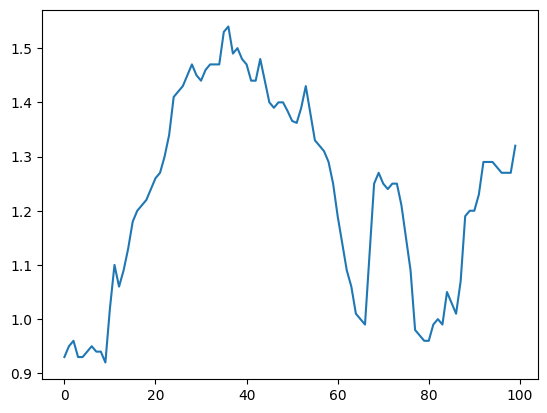

In [41]:
plt.plot(y_train[:100])

In [42]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [113]:
# dataloader = torch.utils.data.DataLoader(data,
#                                         batch_size=32,
#                                         shuffle=False,
#                                         num_workers=0,
#                                         pin_memory=False)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, dilation):
        super(WaveNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=1+dilation - 2^(dilation-1))
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=dilation)
        self.res_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        
    def forward(self, x):
        # print("shape of x: ", x.shape)
        out = F.relu(self.conv1(x))
        # print("shape of first out: ", out.shape)
        out = F.relu(self.conv2(out))
        # print("shape of second out: ", out.shape)
        res = self.res_conv(x)
        # print("shape of res: ", res.shape)
        return out + res

class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, dilations):
        super(WaveNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 32, kernel_size=2, padding=1)
        self.blocks = nn.ModuleList([WaveNetBlock(32, dilation) for dilation in dilations])
        self.final_conv1 = nn.Conv1d(32, 128, kernel_size=3, padding=0)
        self.final_conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=0)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        for block in self.blocks:
            # print("enter the block loop")
            x = block(x)
        x = F.relu(self.final_conv1(x))
        x = F.relu(self.final_conv2(x))
        x = x[:, :, -1]  # Get the last time step
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_channels = 4  # Number of features
output_channels = 1  # Predicting a single value (glucose level)
num_blocks = 4  # Number of WaveNet blocks
dilations = [2**i for i in range(num_blocks)]  # Dilation rates: 1, 2, 4, 8

model = WaveNet(input_channels, output_channels, num_blocks, dilations)
print(model)

# Example of how to define the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


WaveNet(
  (initial_conv): Conv1d(4, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (blocks): ModuleList(
    (0): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (1): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (2): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(4,))
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
      (res_conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    )
    (3): WaveNetBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), dilation=(8,))
      (conv2): Conv1d(32, 32, kernel_size=(2

In [44]:
# Data Preparation (assuming X_train, y_train, X_val, y_val are numpy arrays)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\username\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results

Epoch 1, Validation Loss: 0.10470570784423557
Epoch 2, Validation Loss: 0.10131790598076004
Epoch 3, Validation Loss: 0.1008247854118583
Epoch 4, Validation Loss: 0.10064741621600158
Epoch 5, Validation Loss: 0.1001766930584476
Epoch 6, Validation Loss: 0.10006176700134442
Epoch 7, Validation Loss: 0.10009670965095509
Epoch 8, Validation Loss: 0.09998278447023745
Epoch 9, Validation Loss: 0.10007145811122523
Epoch 10, Validation Loss: 0.1003885924913434
Epoch 11, Validation Loss: 0.10059052336015809
Epoch 12, Validation Loss: 0.10103426888626792
Epoch 13, Validation Loss: 0.10107880084316677
Epoch 14, Validation Loss: 0.10164905743284235
Epoch 15, Validation Loss: 0.10158202343328453
Epoch 16, Validation Loss: 0.10175764839401219
Epoch 17, Validation Loss: 0.10196205087478703
Epoch 18, Validation Loss: 0.10170220506530422
Epoch 19, Validation Loss: 0.10213617765024971
Epoch 20, Validation Loss: 0.1014432514141967
Epoch 21, Validation Loss: 0.10144340419975012
Epoch 22, Validation Loss:

In [46]:
# Calculate RMSE on the validation set
from sklearn.metrics import root_mean_squared_error
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs.permute(0, 2, 1))
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on validation set: {rmse}')

RMSE on validation set: 0.2103913575410843


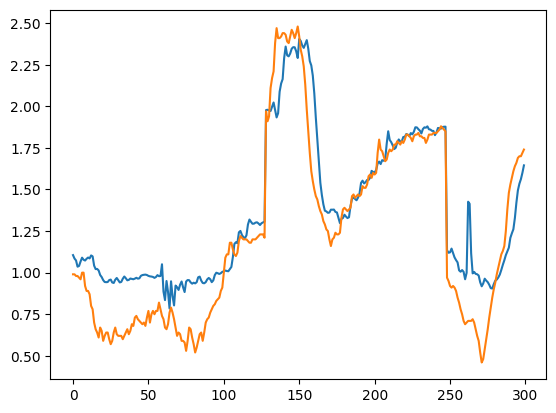

In [47]:
plt.plot(predictions[:300])
plt.plot(actuals[:300])

# Test the model using test dataset

In [50]:
filepath_test = f"C:/Users/username/OneDrive/Desktop/BGprediction/OhioT1DM/2018/test/570-ws-testing.xml"
glucose_test = read_ohio(filepath, "glucose_level", False)

glucose_dict_test = {entry[0]['ts']: entry[0]['value'] for entry in glucose_test}

# Create the multi-channel database
g_data_test = []
for timestamp in glucose_dict_test:
    record = {
        'timestamp': timestamp,
        'glucose_value': glucose_dict_test[timestamp],
        # 'meal_type': None,
        # 'meal_carbs': 0
    }
    
    g_data_test.append(record)

# Create DataFrame
glucose_df_test = pd.DataFrame(g_data_test)

# Convert glucose values to numeric type for analysis
glucose_df_test['glucose_value'] = pd.to_numeric(glucose_df_test['glucose_value'])
glucose_df_test['glucose_value'] = glucose_df_test['glucose_value'] / 100

In [51]:
segments_test = segement_data_as_1hour(glucose_df_test) # segment

interpolated_segements_test = detect_missing_and_spline_interpolate(segments_test) #spline interpolate

segment_1
before:  2021-12-07 22:14:00
after:  2021-12-07 22:34:00
segment_6
before:  2021-12-22 17:03:00
after:  2021-12-22 18:03:00
segment_6
before:  2021-12-22 20:18:00
after:  2021-12-22 20:28:00
segment_8
before:  2021-12-27 07:53:00
after:  2021-12-27 08:28:00
segment_9
before:  2022-01-02 07:32:00
after:  2022-01-02 08:27:00


C:\Users\username\AppData\Local\Temp\ipykernel_19484\2206620972.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
C:\Users\username\AppData\Local\Temp\ipykernel_19484\2206620972.py:26: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


In [52]:
# Include meal info
meal_test = read_ohio(filepath_test, "meal", False)

flattened_meal_data_test = [item[0] for item in meal_test]  # Take the first (and only) item from each sublist

# Convert to DataFrame
meal_df_test = pd.DataFrame(flattened_meal_data_test)

meal_df_test['assigned'] = False

meal_updated_segments_test = update_segments_with_meals(interpolated_segements_test, meal_df_test)

In [53]:
# Include basal
basal_test = read_ohio(filepath_test, "basal", False)

flattened_basal_data_test = [item[0] for item in basal_test]  # Take the first (and only) item from each sublist

# Convert to DataFrame
basal_df_test = pd.DataFrame(flattened_basal_data_test)

basal_df_test['assigned'] = False
basal_df_test['end_ts'] = basal_df_test['ts'].shift(-1)

basal_updated_segments_test = update_segments_with_basal(meal_updated_segments_test, basal_df_test)

In [54]:
# Include bolus
bolus_test = read_ohio_bolus_tempbasal(filepath_test, "bolus", False)

flattened_bolus_data_test = [item[0] for item in bolus_test]  # Take the first (and only) item from each sublist

# Convert to DataFrame
bolus_df_test = pd.DataFrame(flattened_bolus_data_test)

bolus_df_test['assigned'] = False

bolus_updated_segments_test = update_segments_with_bolus(basal_updated_segments_test, bolus_df_test)

Unequal: begin: 2022-01-17 07:23:45end: 2022-01-17 07:53:45
Unequal: begin: 2022-01-17 12:04:02end: 2022-01-17 12:34:02
Unequal: begin: 2022-01-17 19:45:45end: 2022-01-17 20:45:45
Unequal: begin: 2022-01-18 07:14:27end: 2022-01-18 07:44:27
Unequal: begin: 2022-01-18 12:09:25end: 2022-01-18 12:39:25
Unequal: begin: 2022-01-18 19:06:47end: 2022-01-18 19:36:47
Unequal: begin: 2022-01-19 07:03:53end: 2022-01-19 07:33:53
Unequal: begin: 2022-01-19 11:44:39end: 2022-01-19 12:14:39
Unequal: begin: 2022-01-19 16:43:34end: 2022-01-19 17:13:34
Unequal: begin: 2022-01-19 19:13:28end: 2022-01-19 19:43:28
Unequal: begin: 2022-01-20 07:00:39end: 2022-01-20 07:30:39
Unequal: begin: 2022-01-20 11:57:00end: 2022-01-20 12:27:00
Unequal: begin: 2022-01-20 14:40:03end: 2022-01-20 15:10:03
Unequal: begin: 2022-01-20 18:29:00end: 2022-01-20 18:59:00
Unequal: begin: 2022-01-21 06:12:20end: 2022-01-21 06:42:20
Unequal: begin: 2022-01-21 20:15:04end: 2022-01-21 21:15:04
Unequal: begin: 2022-01-22 09:12:07end: 

In [59]:
# Include temp basal
tempbasal_test = read_ohio_bolus_tempbasal(filepath_test, "temp_basal", False)

flattened_tempbasal_data_test = [item[0] for item in tempbasal_test]  # Take the first (and only) item from each sublist

# Convert to DataFrame
tempbasal_df_test = pd.DataFrame(flattened_tempbasal_data_test)

tempbasal_df_test['assigned'] = False

final_updated_segments_test = update_segments_with_tempbasal(bolus_updated_segments_test, tempbasal_df_test)

In [60]:
features_list_test, labels_list_test, new_labels_list_test, raw_glu_list_test = prepare_dataset(final_updated_segments_test)

len of features_list 10677
len of labels_list 10677
The label_lower_percentile is  -0.5599999999999998
The label_upper_percentile is  0.59
after label transform. the len of label list 10677


## Input the processed test data into trained model

In [61]:
features_array_test = np.array(features_list_test)
labels_array_test = np.array(raw_glu_list_test)

# X_test, X_val, y_train, y_val = train_test_split(features_array_test, labels_array_test, test_size=0.2, shuffle= False)
X_test_tensor = torch.tensor(features_array_test, dtype=torch.float32)
y_test_tensor = torch.tensor(labels_array_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [62]:
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs.permute(0, 2, 1))
        predictions.append(outputs)
        actuals.append(targets)

predictions = torch.cat(predictions).cpu().numpy()
actuals = torch.cat(actuals).cpu().numpy()


rmse = root_mean_squared_error(actuals,predictions)
print(f'RMSE on test set: {rmse}')

RMSE on test set: 0.23402634263038635


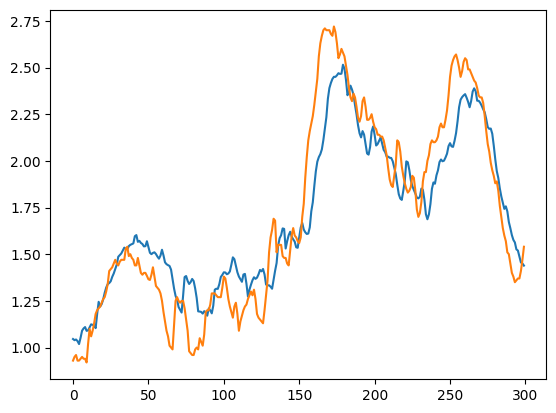

In [63]:
plt.plot(predictions[:300])
plt.plot(actuals[:300])